In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder  # <- Diubah dari OrdinalEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)

In [3]:
df_downsampled = pd.read_csv('../2_preprocessing/data_imbalanced_downsampled.csv')
df_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38038 entries, 0 to 38037
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   content                   38038 non-null  object
 1   score                     38038 non-null  int64 
 2   Lower_Case                38038 non-null  object
 3   Clean_Punct               38038 non-null  object
 4   No_NB                     38038 non-null  object
 5   Clean_Double_WS           38038 non-null  object
 6   translated                38038 non-null  object
 7   tokenized                 38038 non-null  object
 8   tokens_without_stopwords  38038 non-null  object
 9   text_without_stopwords    38038 non-null  object
 10  stemmed_tokens            38038 non-null  object
 11  Labelling                 38038 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.5+ MB


## Modelling


### Splitting Data

In [4]:
from sklearn.model_selection import train_test_split

# Assuming you want to split the 'No_Stopwords' column as features and 'sentiment_label' as target
X = df_downsampled['stemmed_tokens']
y = df_downsampled['Labelling']

# Split data into training (70%) and temporary (validation + test) (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split temporary data into validation (20% of total, 66.67% of temp) and test (10% of total, 33.33% of temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp) # 1/3 of 30% is 10%

X_train = X_train.astype(str)
X_val = X_val.astype(str)
X_test = X_test.astype(str)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (26626,)
Shape of X_val: (7608,)
Shape of X_test: (3804,)
Shape of y_train: (26626,)
Shape of y_val: (7608,)
Shape of y_test: (3804,)


### Machine Learning XGBoost

#### Vectorization

In [5]:
vectorizer = TfidfVectorizer(max_features=5000)

# Fit dan transform HANYA pada data training
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform data validation dan test dengan vectorizer yang sama (JANGAN di-fit lagi)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print("--- Shape data setelah TF-IDF ---")
print("Shape X_train_tfidf:", X_train_tfidf.shape)
print("Shape X_val_tfidf:", X_val_tfidf.shape)
print("Shape X_test_tfidf:", X_test_tfidf.shape)

--- Shape data setelah TF-IDF ---
Shape X_train_tfidf: (26626, 5000)
Shape X_val_tfidf: (7608, 5000)
Shape X_test_tfidf: (3804, 5000)


#### Label Encoding

In [6]:
# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Fit dan transform HANYA pada data training (y_train)
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform data validation dan test dengan encoder yang sama
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Menampilkan hasil encoding untuk verifikasi
print("--- Hasil Label Encoding (Contoh) ---")
print(f"Label asli: {y_train.iloc[:5].values}")
print(f"Label setelah di-encode: {y_train_encoded[:5]}")
print(f"Kelas yang dipelajari: {label_encoder.classes_}") # Akan menunjukkan ['negative' 'positive']

--- Hasil Label Encoding (Contoh) ---
Label asli: ['positive' 'negative' 'negative' 'positive' 'negative']
Label setelah di-encode: [1 0 0 1 0]
Kelas yang dipelajari: ['negative' 'positive']


#### Training Model

In [7]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    eval_metric=['logloss', 'auc', 'error'], # Definisikan metrik di sini
    early_stopping_rounds=10 # <--- PARAMETER DIPINDAHKAN KE SINI
)

print("--- Memulai Training Model ---")
model.fit(
    X_train_tfidf,
    y_train_encoded,
    eval_set=[
        (X_train_tfidf, y_train_encoded),  # Data training
        (X_val_tfidf, y_val_encoded)       # Data validasi
    ],
    verbose=True 
)

print("--- Training Selesai ---")

--- Memulai Training Model ---
[0]	validation_0-logloss:0.66749	validation_0-auc:0.75299	validation_0-error:0.29009	validation_1-logloss:0.66718	validation_1-auc:0.75500	validation_1-error:0.28825
[1]	validation_0-logloss:0.64675	validation_0-auc:0.75329	validation_0-error:0.29051	validation_1-logloss:0.64628	validation_1-auc:0.75556	validation_1-error:0.28904
[2]	validation_0-logloss:0.62943	validation_0-auc:0.75442	validation_0-error:0.29039	validation_1-logloss:0.62890	validation_1-auc:0.75591	validation_1-error:0.28891
[3]	validation_0-logloss:0.61461	validation_0-auc:0.78502	validation_0-error:0.25362	validation_1-logloss:0.61477	validation_1-auc:0.78223	validation_1-error:0.25670
[4]	validation_0-logloss:0.60137	validation_0-auc:0.79921	validation_0-error:0.23789	validation_1-logloss:0.60117	validation_1-auc:0.79984	validation_1-error:0.23686
[5]	validation_0-logloss:0.58933	validation_0-auc:0.82318	validation_0-error:0.23785	validation_1-logloss:0.58895	validation_1-auc:0.82443	

#### Evaluate Model

In [8]:
print("--- Evaluasi pada Data Test ---")
y_pred_encoded = model.predict(X_test_tfidf)

# `y_pred_encoded` sudah dalam bentuk integer
# Gunakan label_encoder untuk inverse_transform
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)
print(f"Hasil Prediksi: {y_pred_labels}")
print(f"Label Sebenarnya: {y_test.values}")

accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"\nAkurasi pada Data Test: {accuracy * 100:.2f}%")

print("\nLaporan Klasifikasi:")
# Gunakan label_encoder.classes_ untuk target_names
target_names = label_encoder.classes_
print(classification_report(y_test_encoded, y_pred_encoded, target_names=target_names))

--- Evaluasi pada Data Test ---
Hasil Prediksi: ['positive' 'negative' 'negative' ... 'negative' 'negative' 'negative']
Label Sebenarnya: ['positive' 'negative' 'negative' ... 'negative' 'negative' 'negative']

Akurasi pada Data Test: 87.80%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.90      0.85      0.87      1902
    positive       0.86      0.90      0.88      1902

    accuracy                           0.88      3804
   macro avg       0.88      0.88      0.88      3804
weighted avg       0.88      0.88      0.88      3804



### Cross Validation

In [18]:
# %%
def train_xgb(model, X_train_tfidf, y_train_encoded, X_val_tfidf, y_val_encoded, X_full, y_full, encoder):
    """
    Fungsi untuk melatih model, mengevaluasi pada validation set,
    dan melakukan cross-validation pada keseluruhan dataset.
    """
    model.fit(X_train_tfidf, y_train_encoded)
    
    # Prediksi pada validation set
    y_pred = model.predict(X_val_tfidf)
    y_proba = model.predict_proba(X_val_tfidf)[:, 1]
    
    # Evaluasi pada validation set
    acc = accuracy_score(y_val_encoded, y_pred)
    prec = precision_score(y_val_encoded, y_pred)
    rec = recall_score(y_val_encoded, y_pred)
    f1 = f1_score(y_val_encoded, y_pred)
    auc = roc_auc_score(y_val_encoded, y_proba)
    
    print("--- Evaluasi pada Validation Set ---")
    print(f"Akurasi: {acc:.4f}")
    print(f"Presisi: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC ROC: {auc:.4f}")

    # --- PERUBAHAN DIMULAI DI SINI ---
    
    # Cross Validation pada keseluruhan data
    X_full_tfidf = vectorizer.transform(X_full)
    # Gunakan encoder yang sudah di-fit (diteruskan sebagai parameter)
    y_full_encoded = encoder.transform(y_full)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
    
    # Ubah scoring untuk hanya menyertakan neg_log_loss (untuk val_loss) dan accuracy (untuk val_acc)
    scoring = ['neg_log_loss', 'accuracy'] 
    cv_results = cross_validate(model, X_full_tfidf, y_full_encoded, cv=cv, scoring=scoring, return_train_score=False)

    print("\n===== Cross-validation summary =====") # Header baru
    
    # Ambil hasil per fold
    # Kalikan -1 karena scikit-learn mengembalikan 'neg_log_loss' (nilai negatif)
    fold_losses = cv_results['test_neg_log_loss'] * -1 
    fold_accs = cv_results['test_accuracy']
    
    for i in range(len(fold_losses)):
        print(f"Fold {i+1}: val_loss={fold_losses[i]:.4f} | val_acc={fold_accs[i]:.4f}")
        
    # Hitung dan cetak rata-rata
    avg_loss = np.mean(fold_losses)
    std_loss = np.std(fold_losses)
    avg_acc = np.mean(fold_accs)
    std_acc = np.std(fold_accs)
    
    print(f"Average val loss: {avg_loss:.4f} +/- {std_loss:.4f}")
    print(f"Average val acc : {avg_acc:.4f} +/- {std_acc:.4f}")

    # --- PERUBAHAN SELESAI ---

    # Confusion Matrix
    cm = confusion_matrix(y_val_encoded, y_pred)
    target_names = encoder.classes_ # Menggunakan encoder.classes_
    
    print("\n--- Laporan Klasifikasi (pada Validation Set) ---")
    print(classification_report(y_val_encoded, y_pred, target_names=target_names))
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Validation Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val_encoded, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Validation Set)')
    plt.legend()
    plt.show()

--- Evaluasi pada Validation Set ---
Akurasi: 0.8799
Presisi: 0.8671
Recall: 0.8972
F1 Score: 0.8819
AUC ROC: 0.9431

===== Cross-validation summary =====
Fold 1: val_loss=0.3240 | val_acc=0.8774
Fold 2: val_loss=0.3181 | val_acc=0.8828
Fold 3: val_loss=0.3212 | val_acc=0.8789
Fold 4: val_loss=0.3229 | val_acc=0.8767
Fold 5: val_loss=0.3187 | val_acc=0.8868
Average val loss: 0.3210 +/- 0.0023
Average val acc : 0.8805 +/- 0.0038

--- Laporan Klasifikasi (pada Validation Set) ---
              precision    recall  f1-score   support

    negative       0.89      0.86      0.88      3804
    positive       0.87      0.90      0.88      3804

    accuracy                           0.88      7608
   macro avg       0.88      0.88      0.88      7608
weighted avg       0.88      0.88      0.88      7608



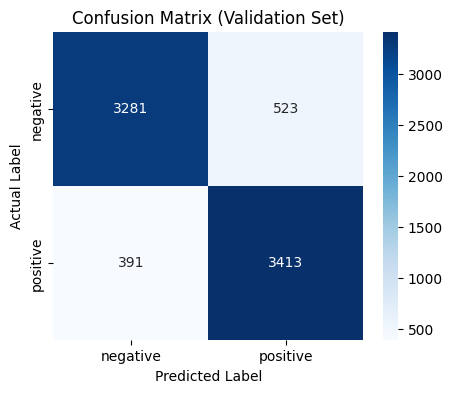

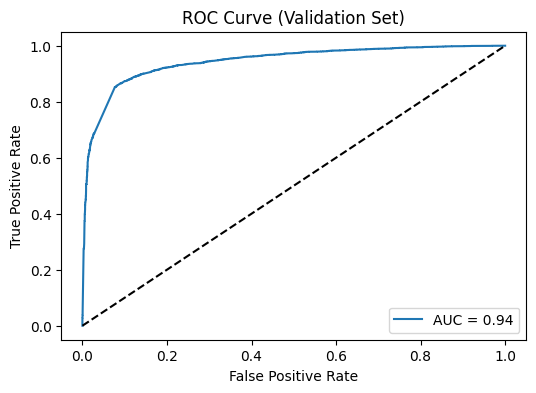

In [19]:
# Inisialisasi model XGBoost (Model Kedua, untuk Cross-Validation)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss'
)

# Panggil fungsi untuk melatih dan mengevaluasi model
# Kita teruskan juga X dan y (data mentah) untuk proses cross-validation di dalam fungsi
# DAN label_encoder yang sudah di-fit
train_xgb(xgb_model, X_train_tfidf, y_train_encoded, X_val_tfidf, y_val_encoded, X, y, label_encoder)


--- Evaluasi Final pada Data Test (Model Kedua) ---
Akurasi pada Data Test: 88.51%

Laporan Klasifikasi (Data Test):
              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      1902
    positive       0.87      0.90      0.89      1902

    accuracy                           0.89      3804
   macro avg       0.89      0.89      0.89      3804
weighted avg       0.89      0.89      0.89      3804


Confusion Matrix:
[[1649  253]
 [ 184 1718]]

--- Visualisasi Confusion Matrix (Test Set XGBoost) ---


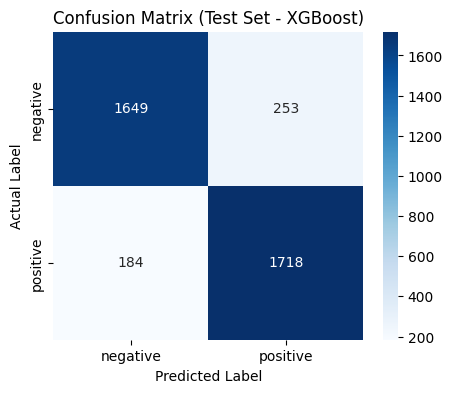

In [21]:
# %%
# #### Evaluasi Final pada Data Test (Model Kedua)
print("\n--- Evaluasi Final pada Data Test (Model Kedua) ---")
y_pred_test = xgb_model.predict(X_test_tfidf)

accuracy_test = accuracy_score(y_test_encoded, y_pred_test)
print(f"Akurasi pada Data Test: {accuracy_test * 100:.2f}%")

print("\nLaporan Klasifikasi (Data Test):")
# Gunakan label_encoder.classes_ untuk target_names
print(classification_report(y_test_encoded, y_pred_test, target_names=label_encoder.classes_))

# --- TAMBAHAN UNTUK MENYERUPAI BI-LSTM ---

# 1. Hitung dan cetak Confusion Matrix (format teks)
cm_xgb_test = confusion_matrix(y_test_encoded, y_pred_test)
print('\nConfusion Matrix:')
print(cm_xgb_test)

# 2. Dapatkan nama kelas dari label_encoder (didefinisikan di sel 9a1c0ca6)
target_names = label_encoder.classes_

# 3. Buat plot heatmap
print("\n--- Visualisasi Confusion Matrix (Test Set XGBoost) ---")
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_xgb_test, 
    annot=True, 
    fmt='d',  # Format angka sebagai integer
    cmap='Blues', 
    xticklabels=target_names, 
    yticklabels=target_names
)
plt.title('Confusion Matrix (Test Set - XGBoost)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()